# Siamese-FC

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Lambda, Reshape, Flatten
from keras.models import Model

Using TensorFlow backend.


**Build Model**

In [2]:
def conv_layer(filters, kernel_dim, stride_len):
    return [Conv2D(filters, kernel_dim, strides=stride_len,
                  padding='valid', activation='relu', kernel_initializer='glorot_normal')]

def conv_block(filters, kernel_dim, stride_len):
    batch_norm = [BatchNormalization(axis=3)]
    return conv_layer(filters, kernel_dim, stride_len) + batch_norm

def max_pool():
    return [MaxPool2D(pool_size=3, strides=2, padding='valid')]

def alex_net_layers():
    layers = []
    layers += conv_block(48, 11, 2)
    layers += max_pool()
    layers += conv_block(128, 5, 1)
    layers += max_pool()
    layers += conv_block(48, 3, 1)
    layers += conv_block(48, 3, 1)
    layers += conv_layer(32, 3, 1)
    return layers

def apply_layers(x, layers):
    out = x
    for layer in layers:
        out = layer(out)
    return out

def add_dimension(t):
    return tf.reshape(t, (1,) + t.shape)

def cross_correlation(inputs):
    x = inputs[0]
    x = tf.reshape(x, [1] + x.shape.as_list())
    z = inputs[1]
    z = tf.reshape(z, z.shape.as_list() + [1])
    return tf.nn.convolution(x, z, padding='VALID', strides=(1,1))

def x_corr_map(inputs):
    # Note that dtype MUST be specified, otherwise TF will assert that the input and output structures are the same,
    # which they most certainly are NOT.
    return tf.map_fn(cross_correlation, inputs, dtype=tf.float32, infer_shape=False)
    
def x_corr_layer():
    return Lambda(x_corr_map, output_shape=(1, 17, 17, 1))
    
exemplar = Input(shape=(127, 127, 3))
search = Input(shape=(255, 255, 3))

alex_net = alex_net_layers()

exemplar_features = apply_layers(exemplar, alex_net)
search_features = apply_layers(search, alex_net)

In [3]:
kernel_shape = (3,3,3)
target_shape = (5,5,3)

kernel = Input(shape=kernel_shape)
target = Input(shape=target_shape)

kernel_input = np.empty((2,) + kernel_shape)
kernel_input[0] = np.ones(kernel_shape)
kernel_input[1] = np.full(kernel_shape, 2)

target_input = np.empty((2,) + target_shape)
target_input[0] = np.ones(target_shape)
target_input[1] = np.ones(target_shape)

out = Lambda(x_corr_map)([target, kernel])
flat = Flatten()(out)

model = Model(inputs=[target, kernel], outputs=flat)
print(model.predict([target_input, kernel_input]))


[[ 27.  27.  27.  27.  27.  27.  27.  27.  27.]
 [ 54.  54.  54.  54.  54.  54.  54.  54.  54.]]


In [4]:
score_map = x_corr_layer()([search_features, exemplar_features])
flat = Flatten()(score_map)
model = Model(inputs=[search, exemplar], outputs=flat)

test_exemplar = np.ones((2,127,127,3))
test_search = np.ones((2,255,255,3))

model.predict([test_search, test_exemplar]).shape

(2, 289)

In [5]:
conv_test = Model(inputs=[search, exemplar], outputs=[search_features, exemplar_features])
outs = conv_test.predict([test_search, test_exemplar])
exemplar_test = Model(inputs=exemplar, outputs=apply_layers(exemplar, alex_net_layers()))
search_test = Model(inputs=search, outputs=apply_layers(search, alex_net_layers()))
print(outs[0].shape)
print(outs[1].shape)

(2, 22, 22, 32)
(2, 6, 6, 32)


In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
from keras.preprocessing import image

x_dir = '../sample/x/'
z_dir = '../sample/z/'

def load_images(directory, dimension, n_images, suffix):
    img_array = np.empty((n_images, dimension, dimension, 3))
    for i in range(1, n_images + 1):
        img = image.load_img(directory + str(i) + suffix, target_size=(dimension, dimension))
        img_array[i - 1] = image.img_to_array(img)
    return img_array

In [14]:
search = load_images(x_dir, 255, 100, ".x.jpg")

In [15]:
exemplar = load_images(z_dir, 127, 100, ".z.jpg")

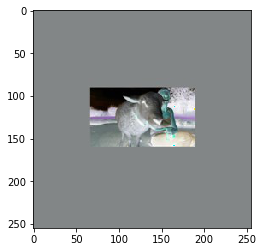

In [16]:
plt.imshow(search[0])

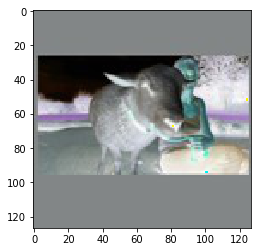

In [17]:
plt.imshow(exemplar[0])

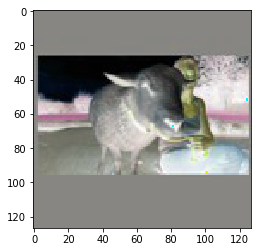

In [18]:
plt.imshow(np.flip(exemplar[0], axis=2))

**Make label prototype for search images**

In [51]:
def inclusive_range(start, end):
    return range(start, end + 1)

def euclidean_distance(x1, y1, x2, y2):
    return sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Create labels for a score map of size dim x dim, where the label of a score is positive for any cell within
# radius of the center, and negative otherwise.
def make_label(dim, radius):
    label = np.full((dim, dim), -1)
    center = int(dim / 2.0)
    start = center - radius
    end = center + radius
    for i in inclusive_range(start, end):
        for j in inclusive_range(start, end):
            if euclidean_distance(i, j, center, center) <= radius:
                label[i,j] = 1
    return label

def make_label_weights(labels):
    weights = np.empty(labels.shape)
    values, counts = np.unique(labels, return_counts=True)
    weights[np.where(labels == 1)] = 0.5 / counts[1]
    weights[np.where(labels == -1)] = 0.5 / counts[0]
    return weights

In [52]:
print(make_label(5, 1))

[[-1 -1 -1 -1 -1]
 [-1 -1  1 -1 -1]
 [-1  1  1  1 -1]
 [-1 -1  1 -1 -1]
 [-1 -1 -1 -1 -1]]


In [53]:
print(make_label_weights(make_label(5,1)))

[[ 0.025  0.025  0.025  0.025  0.025]
 [ 0.025  0.025  0.1    0.025  0.025]
 [ 0.025  0.1    0.1    0.1    0.025]
 [ 0.025  0.025  0.1    0.025  0.025]
 [ 0.025  0.025  0.025  0.025  0.025]]
